# Build your very own custom Classifier

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [14]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os

# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

## Project Configuration

In [35]:
def getconfig(cfg_in={}):
    cfg = {}
    cfg["bs"] = 16
    cfg["image_dir"] = "/home/cecuser/FastAI/images"
    cfg["classes"] = ["cars","busses","trucks"]
    cfg["num_images"] = {"train":40,"valid":20,"test":20}
    cfg["d_partitions"] = list(cfg["num_images"].keys())                 
    cfg["jpeginfo"] ="/home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo"
   
    # overwrite configs if passed
    for (k,v) in cfg_in.items() :
        nprint("Overriding Config {}:{} with {}".format(k,cfg[k],v))
        cfg[k] = v
    return cfg

# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

Here we are going to build our own dataset !!  Think of 3 categories you would like to classify images.  In this example, we will use 
* busses
* trucks 
* cars

We will use an open source tool called *googliser* to download our images from google images

In [36]:
mycfg = {
    "classes":["people wearing masks","people posing street"],
}
cfg=getconfig(mycfg)
cfg["d_partitions"]

**getconfig** : Overriding Config classes:['cars', 'busses', 'trucks'] with ['people wearing masks', 'people posing street']


['train', 'valid', 'test']

In [37]:
def class_folder_name(base,d_part,cls) :
    return base+"/"+d_part+"/"+ cls.replace(" ","_")

def makeDirIfNotExist(directory) :
    if not os.path.exists(directory):  
        nprint("Making directory {}".format(directory))
        os.makedirs(directory) 
    else :
        nprint("Directory {} already exists .. ".format(directory))

for d_part in cfg["d_partitions"] :
    for cls in cfg["classes"] :
        directory=class_folder_name(cfg['image_dir'],d_part,cls)
        makeDirIfNotExist(directory)


**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/train/people_wearing_masks
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/train/people_posing_street
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/valid/people_wearing_masks
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/valid/people_posing_street
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/test/people_wearing_masks
**makeDirIfNotExist** : Making directory /home/cecuser/FastAI/images/test/people_posing_street


# Install Googliser here.  This handy application will download our images

In [38]:
# install googliser
os.chdir(cfg['image_dir'])
googliser = cfg['image_dir']+"/googliser/googliser.sh"
!git clone https://github.com/teracow/googliser


Cloning into 'googliser'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2692 (delta 41), reused 47 (delta 21), pack-reused 2622
Receiving objects: 100% (2692/2692), 5.28 MiB | 0 bytes/s, done.
Resolving deltas: 100% (1639/1639), done.


In [39]:
cfg['num_images']

{'train': 40, 'valid': 20, 'test': 20}

In [40]:
cmd = "ls -lart"
!ls {googliser}

/home/cecuser/FastAI/images/googliser/googliser.sh


In [41]:
def download_images(cfg):
    for d_p in cfg["d_partitions"] :
        for cls in cfg["classes"] :
            current_dir =class_folder_name(cfg['image_dir'],d_p,cls)
            os.chdir(current_dir)
            command = googliser + \
                      " --o {}".format(current_dir) +\
                      " --phrase \"{}\"".format(cls) + \
                      " --parallel 10 --upper-size 500000 --lower-size 2000 " + \
                      " -n {}".format(cfg['num_images'][d_p]) + \
                      " --format jpg --quiet --timeout 10"
            
            nprint(command)
            !{command}
    nprint("Downloads complete!")
download_images(cfg)
# for cls in classes :
#     print("Download {} training images to {}".format(cls,traindir))
#     ! {c['image_dir']}/googliser/googliser.sh --phrase {cls} --title {cls} --parallel 10 \
#       --upper-size 500000 --lower-size 2000  -n {c['num_images']} --quiet \
#        --format png
# os.chdir(valdir)
# for cls in classes :
#     print("Download {} validation images to {}".format(cls,valdir))
#     ! {c['image_dir']}/googliser/googliser.sh --phrase {cls} --title {cls} --parallel 10 --upper-size 500000 --lower-size 2000  -n 5 --quiet
# 
#!../googliser/googliser.sh --phrase "trucks" --title "trucks" --parallel 10 --upper-size 500000 --lower-size 2000  -n 30 --quiet
#!../googliser/googliser.sh --phrase "motorcycles" --title "motorcycles" --parallel 10 --upper-size 500000 --lower-size 2000  -n 30 --quiet


**download_images** : /home/cecuser/FastAI/images/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_wearing_masks --phrase "people wearing masks" --parallel 10 --upper-size 500000 --lower-size 2000  -n 40 --format jpg --quiet --timeout 10
links list exhausted!
**download_images** : /home/cecuser/FastAI/images/googliser/googliser.sh --o /home/cecuser/FastAI/images/train/people_posing_street --phrase "people posing street" --parallel 10 --upper-size 500000 --lower-size 2000  -n 40 --format jpg --quiet --timeout 10
**download_images** : /home/cecuser/FastAI/images/googliser/googliser.sh --o /home/cecuser/FastAI/images/valid/people_wearing_masks --phrase "people wearing masks" --parallel 10 --upper-size 500000 --lower-size 2000  -n 20 --format jpg --quiet --timeout 10
**download_images** : /home/cecuser/FastAI/images/googliser/googliser.sh --o /home/cecuser/FastAI/images/valid/people_posing_street --phrase "people posing street" --parallel 10 --upper-size 500000 --lower-s

## Clean up downloaded images that are not proper jpeg format ..

In [42]:
# clean with jpeginfo! 
os.chdir(cfg['image_dir'])
print("Search for Error files ......")
command = "find . -name \"*.jpg\" | xargs -i {}".format(cfg["jpeginfo"]) +\
          " -c {} | grep ERROR"
print("Running command : {}".format(command))
!{command}
print("Removing any error files listed above")
command = command + ' | cut -d " " -f1 | xargs -i rm {} '
print("Running command : {}".format(command))
!{command}

# find . -name "*.jpg" | xargs -i ./jpeginfo -c {}
# find . -name "*.jpg" | xargs -i ./jpeginfo -c {} | grep ERROR | cut -d " " -f1 | xargs -i rm {}

Search for Error files ......
Running command : find . -name "*.jpg" | xargs -i /home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo -c {} | grep ERROR
./train/people_wearing_masks/image(0034).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_wearing_masks/image(0054).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./valid/people_wearing_masks/image(0034).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./test/people_wearing_masks/image(0034).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
Removing any error files listed above
Running command : find . -name "*.jpg" | xargs -i /home/cecuser/aicoc-ai-immersion/FastAI/jpeginfo -c {} | grep ERROR | cut -d " " -f1 | xargs -i rm {} 


In [43]:
#path = untar_data(URLs.PETS); path
path = Path(cfg['image_dir'])

In [44]:
path.ls()

[PosixPath('/home/cecuser/FastAI/images/train'),
 PosixPath('/home/cecuser/FastAI/images/valid'),
 PosixPath('/home/cecuser/FastAI/images/test'),
 PosixPath('/home/cecuser/FastAI/images/googliser')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

## Create Data Bunch

In [45]:
# https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder
## Important, batch size should be set lower than the number of images you have
data=None
try :
    data = ImageDataBunch.from_folder(path=cfg['image_dir'],
                train="train",valid="valid",test="test",no_check=True,
                size=224,num_workers=4,bs=cfg["bs"]).normalize(imagenet_stats)
except OSError as err: 
    print("OS error: {0}".format(err))
    
#/gpfs/home/s4s004/vanstee/anaconda3/envs/powerai-fastai/lib/python3.7/site-packages/fastai/basic_data.py:262: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in 
#            self.train_ds: 24,33,47,70,32
#  warn(warn_msg)


In [46]:
data

ImageDataBunch;

Train: LabelList (73 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Valid: LabelList (39 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks,people_wearing_masks
Path: /home/cecuser/FastAI/images;

Test: LabelList (39 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/cecuser/FastAI/images

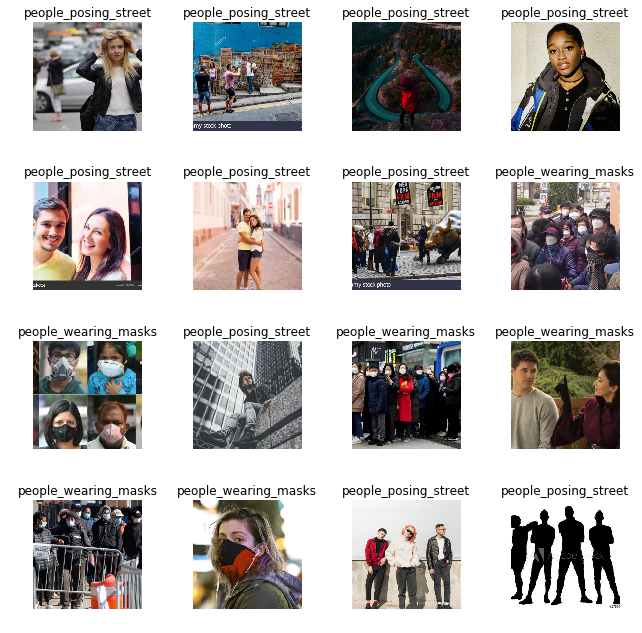

In [47]:
data.show_batch(rows=4, figsize=(9,9))

In [49]:
print(data.classes)
len(data.classes),data.c

['people_posing_street', 'people_wearing_masks']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [50]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [51]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [52]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.278428,0.721079,0.282051,00:06
1,0.816297,0.294471,0.128205,00:05
2,0.715259,0.152937,0.051282,00:05
3,0.568827,0.136336,0.025641,00:05


In [53]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

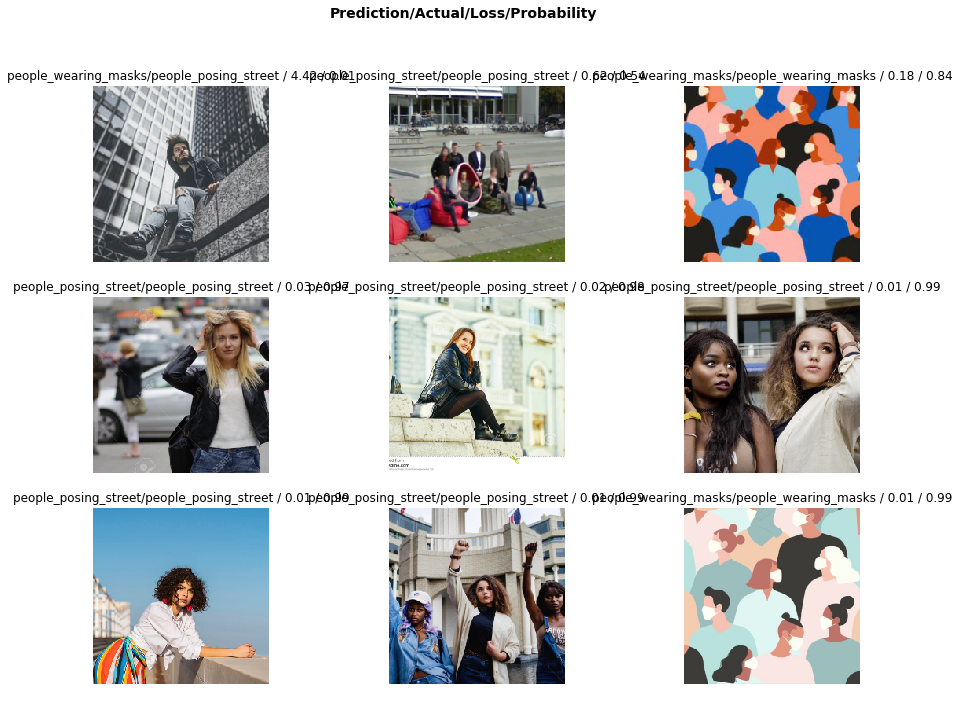

In [55]:
interp.plot_top_losses(9, figsize=(15,11))

In [56]:
doc(interp.plot_top_losses)

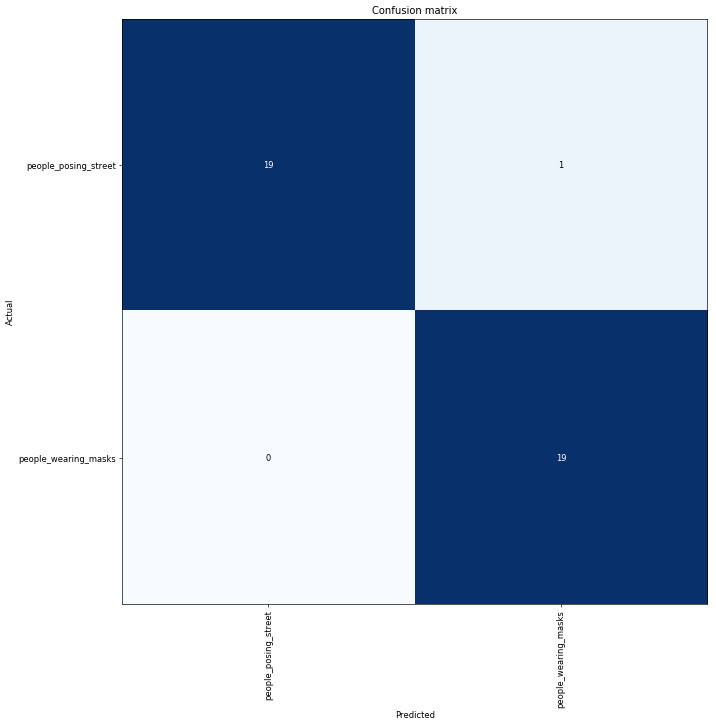

In [57]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [58]:
interp.most_confused(min_val=2)

[]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [59]:
learn.unfreeze()

In [60]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.122878,2.268397,0.153846,00:05


In [61]:
learn.load('stage-1');

In [62]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


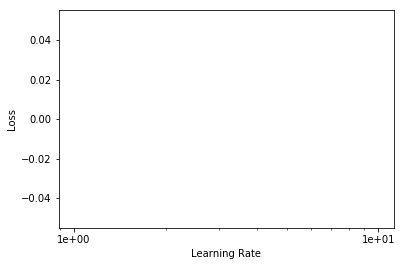

In [63]:
learn.recorder.plot()

In [64]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.104201,0.092591,0.025641,00:05
1,0.093064,0.062145,0.025641,00:05


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes